hotel_address — адрес отеля;\
additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.\
review_date — дата, когда рецензент разместил соответствующий отзыв;\
average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;\
hotel_name — название отеля;\
reviewer_nationality — страна рецензента;\
negative_review — отрицательный отзыв, который рецензент дал отелю;\
review_total_negative_word_counts — общее количество слов в отрицательном отзыв;\
total_number_of_reviews — общее количество действительных отзывов об отеле;\
positive_review — положительный отзыв, который рецензент дал отелю;\
review_total_positive_word_counts — общее количество слов в положительном отзыве.\
total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;\
reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;\
tags — теги, которые рецензент дал отелю;\
days_since_review — количество дней между датой проверки и датой очистки;\
lat — географическая широта отеля;\
lng — географическая долгота отеля.

In [87]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2


# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)


%matplotlib inline
import matplotlib.pyplot as plt # библиотека визуализации
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10, 8)})


import warnings
warnings.filterwarnings('ignore')


from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
from sklearn.model_selection import train_test_split

In [89]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [90]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

In [91]:
# Подгрузим наши данные из соревнования
df_train = pd.read_csv('data/hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv.zip') # самбмишн

In [92]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [93]:
df_train

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.00,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.51,-0.14
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.30,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.52,-0.12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.90,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.50,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.85,2.33
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.00,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.89,2.39
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.50,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.60,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.39,4.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.00,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.80,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.49,-0.19
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.40,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.20,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.19,16.40
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.80,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.30,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.52,-0.13
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.10,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.20,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.52,-0.16


In [94]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [95]:
df_test

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.10,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.53,9.17
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.60,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.39,4.83
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.30,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.39,2.16
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.10,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.48,9.20
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.10,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.37,4.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128930,Viale Monza 132 Distretto Viale Monza 20127 Mi...,53,2/3/2016,8.10,Best Western Antares Hotel Concorde,Greece,No Negative,0,984,nice breakfast,4,14,"[' Business trip ', ' Couple ', ' Double Room ...",547 day,45.50,9.22
128931,Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...,46,6/18/2016,7.80,Medinaceli,United States of America,No Negative,0,523,Beautiful historic hotel in great location in...,24,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",411 day,41.38,2.18
128932,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,260,7/6/2017,8.00,Suite Hotel 900 m zur Oper,New Zealand,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,23,1,"[' Business trip ', ' Solo traveler ', ' Singl...",28 days,48.19,16.37
128933,Corso Concordia 1 Milan City Center 20129 Mila...,159,12/26/2015,9.00,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,7,"[' Leisure trip ', ' Solo traveler ', ' Execut...",586 day,45.47,9.21


In [96]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [97]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [98]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [118]:
# Преобразую дату
data['review_date'] = pd.to_datetime(data['review_date'])

In [119]:
def reformat_days_since_review(days_since_review):
    days_str = str(days_since_review)
    
    days = days_str.split()[0]
    
    return int(days)

In [120]:
data['days_since_review'] = data['days_since_review'].apply(reformat_days_since_review)

<Figure size 720x720 with 0 Axes>

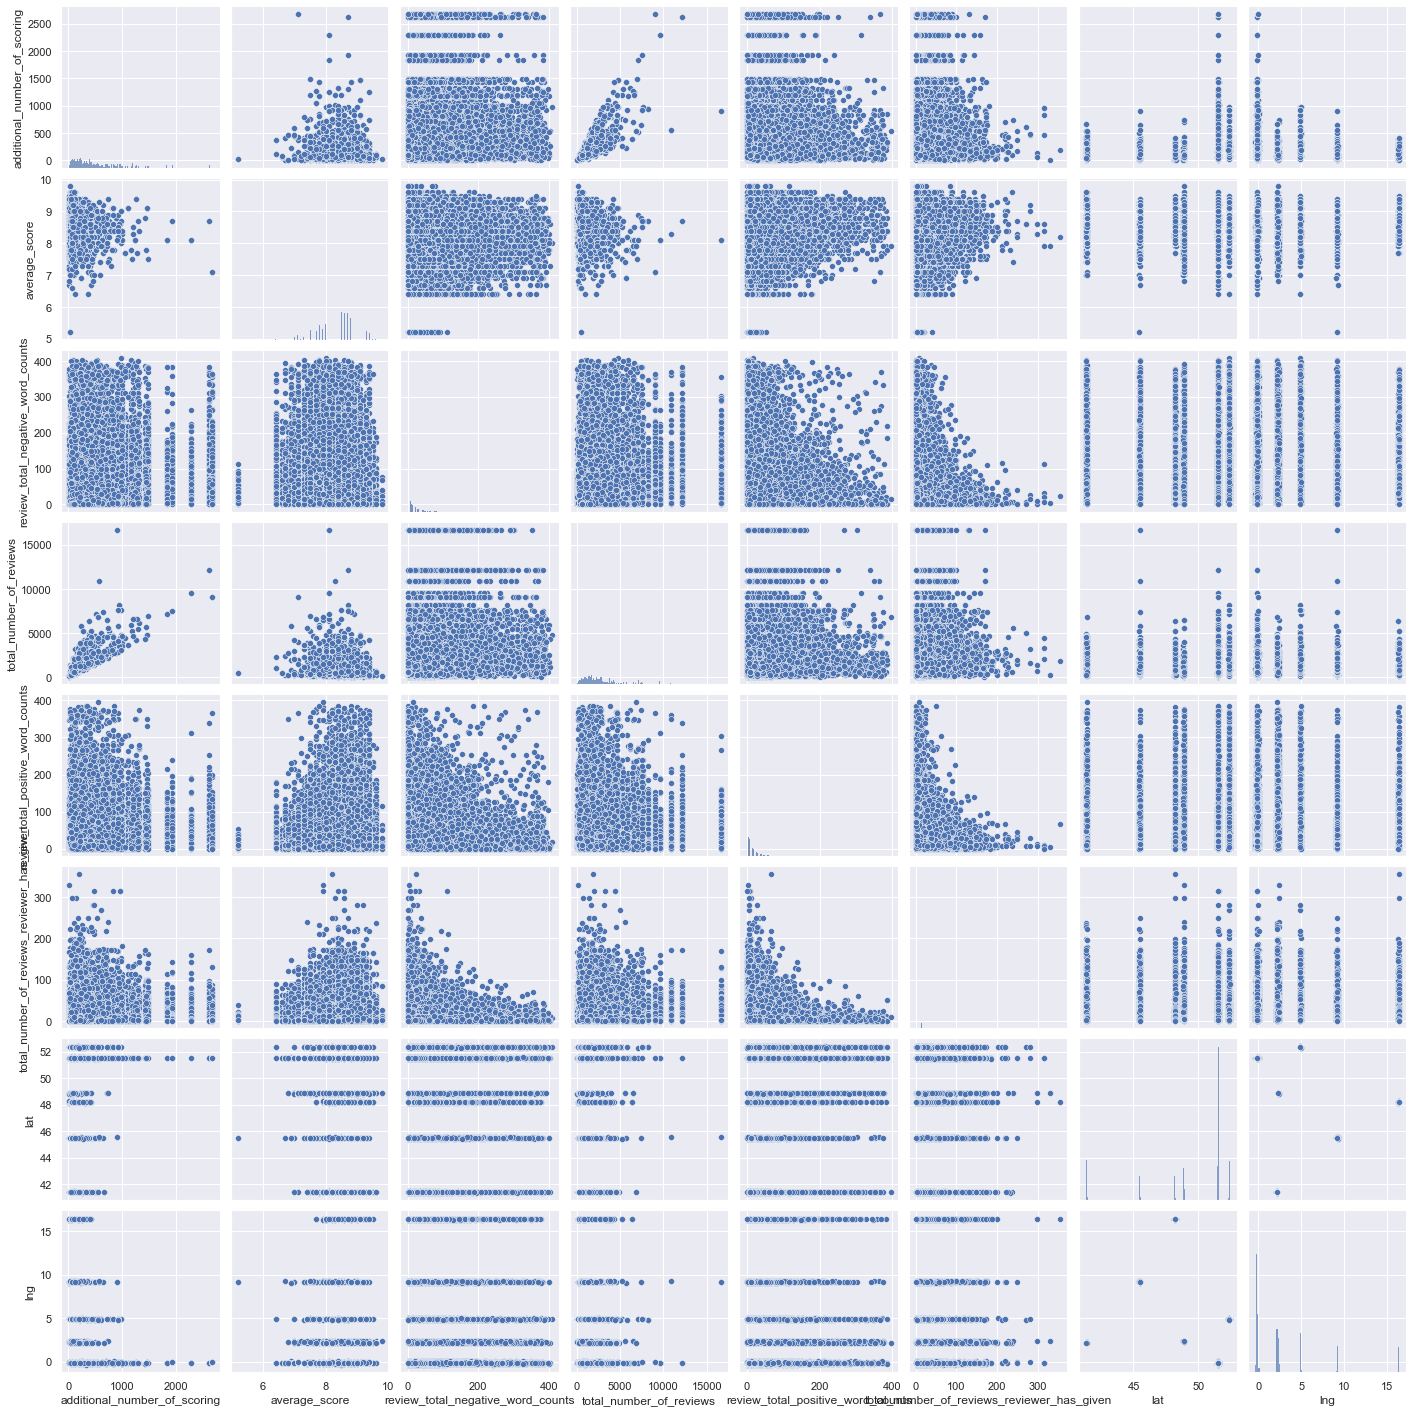

In [100]:
fig = plt.figure(figsize=(10, 10))
ax = sns.pairplot(data[data.columns[:-2]])
fig.show()

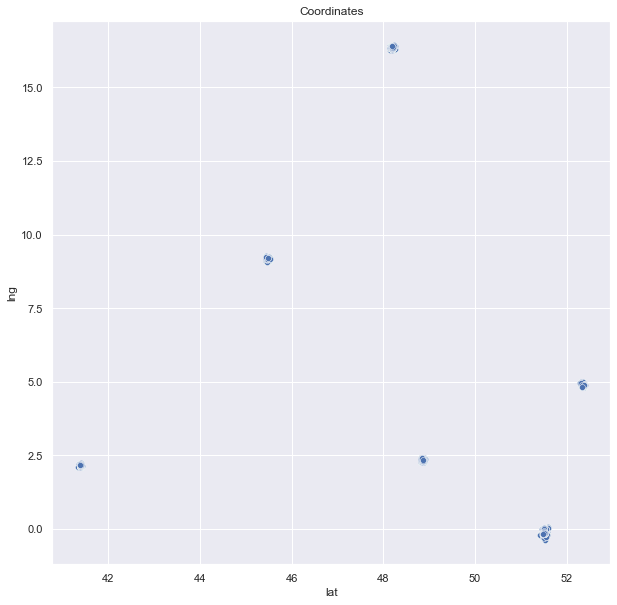

In [101]:
fig = plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='lat', y='lng', data=data)
ax.set_title('Coordinates')
fig.show()

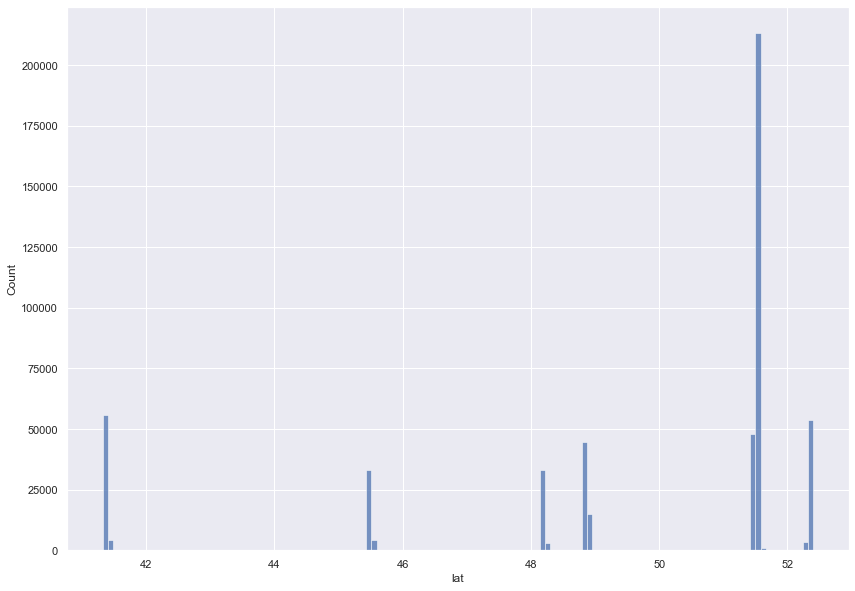

In [102]:
fig = plt.figure(figsize=(14, 10))
sns.histplot(data['lat'])
fig.show()

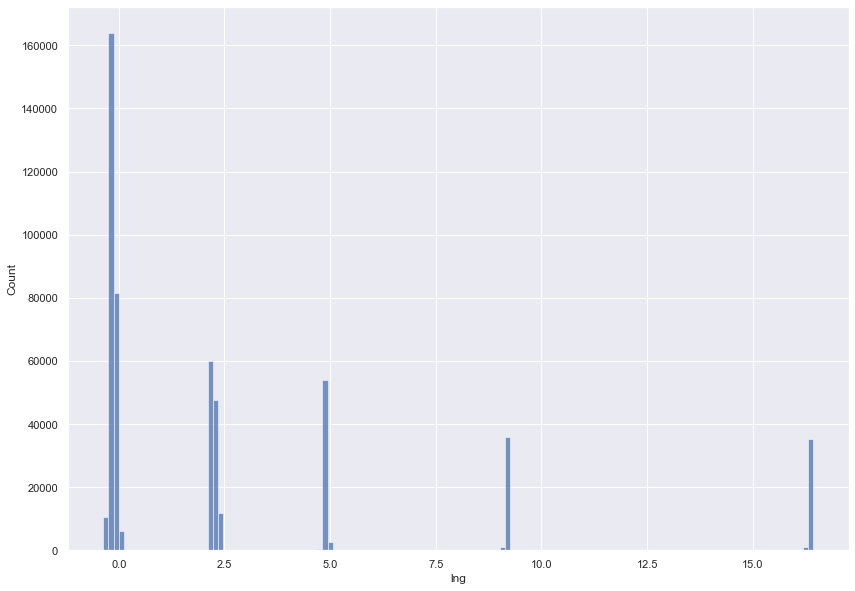

In [103]:
fig = plt.figure(figsize=(14, 10))
sns.histplot(data['lng'])
fig.show()

In [106]:
def get_country(hotel_address):
    address_list = hotel_address.split()
    last = address_list[-1]
    
    if last == 'Kingdom':
        return 'United Kingdom'
    else:
        return last

In [107]:
def get_city(hotel_address):
    address_list = hotel_address.split()
    last = address_list[-1]
    
    if last == 'Kingdom':
        return address_list[-5]
    else:
        return address_list[-2]

In [108]:
data['Country'] = data['hotel_address'].apply(get_country)

In [109]:
data['City'] = data['hotel_address'].apply(get_city)

In [110]:
# Всего 6 стран. Все европа. По scatterplot так же было понятно, что всего 6 областей где точки сгруппировались
data['Country'].value_counts(True) * 100

United Kingdom   50.86
Spain            11.66
France           11.62
Netherlands      11.09
Austria           7.55
Italy             7.21
Name: Country, dtype: float64

In [111]:
# И всего 6 городов, по одному на каждую из стран. Такой же категориальный признак что и страна то же распределение.
# Тут сразу понятно что признаки повторяют друг друга, есть смысл оставить только один.
data['City'].value_counts(True) * 100

London      50.86
Barcelona   11.66
Paris       11.62
Amsterdam   11.09
Vienna       7.55
Milan        7.21
Name: City, dtype: float64

#### Итого:
1. Из адреса вытягивают только город, так как-то красивее, в старне вообще нет смысла с таким маленьким количеством уникальных стран и городов
2. Исходный адрес дропаю
3. Признаки lat и lng по предварительному анализу так же сложились в 6 областей, по сути повтаряюя признак страна/город, но там есть пропуски и еще нужно бить все это на категории. Дропаю! После того как вытащили из адреса города, этот признак не несет никакой дополнительной эксклюзивной информации

In [113]:
data.drop(['hotel_address', 'Country', 'lat', 'lng'], axis=1, inplace=True)

KeyError: "['hotel_address', 'Country', 'lat', 'lng'] not found in axis"

In [124]:
columns = list(data.columns)
columns.remove('reviewer_score')
columns.remove('sample')
columns

['additional_number_of_scoring',
 'review_date',
 'average_score',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'positive_review',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'tags',
 'days_since_review',
 'City']

<Figure size 720x720 with 0 Axes>

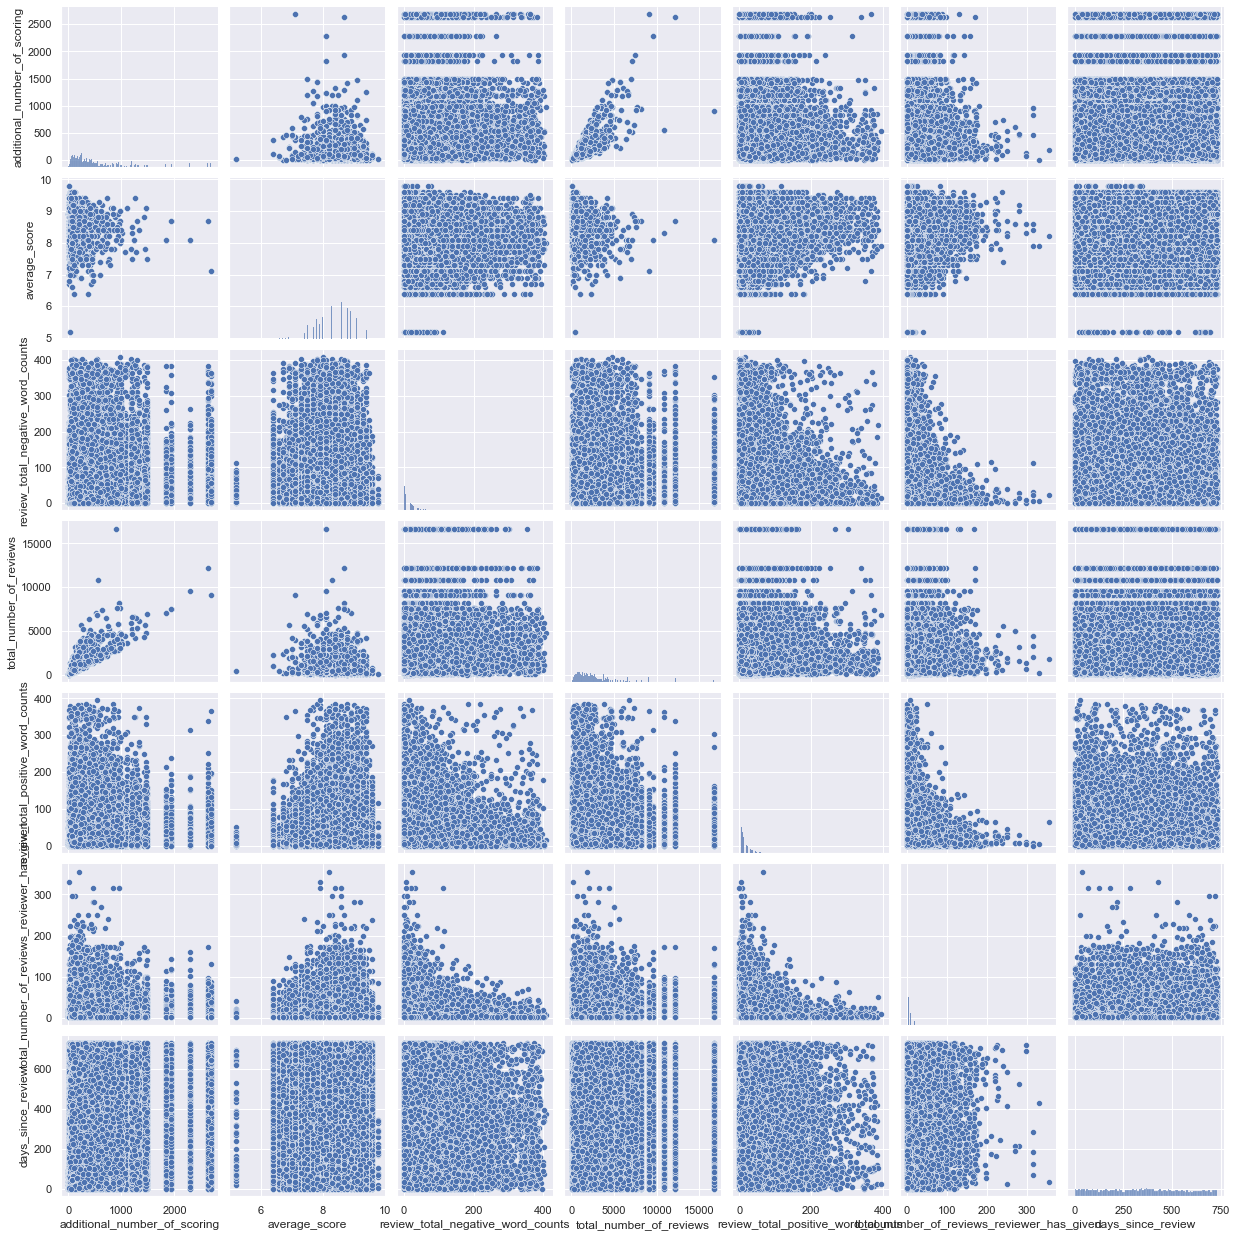

In [127]:
fig = plt.figure(figsize=(10, 10))
ax = sns.pairplot(data[columns])
fig.show()

Из признака tags кроме самих тэгов можно вытащить количество тегов сколько конкретный респондент поставил. tags_num.

Из города можно вытянуть бинарный признак is_capital. Столица ли страны.
Так же можно загрузить данные по населению в странах и в конкретных городах.
И посчитать насколько город большой. Доля населения проживающая в городе относительно всей страны.

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

In [115]:
data['hotel_name'].to_list()

['Hotel Da Vinci',
 'Urban Lodge Hotel',
 'Alexandra Barcelona A DoubleTree by Hilton',
 'Hotel Principe Di Savoia',
 'Hotel Esther a',
 'Holiday Inn London Bloomsbury',
 'Holiday Inn London Wembley',
 'Novotel London West',
 'Hotel Saint Petersbourg Opera',
 'St George Hotel',
 'Barcel Milan',
 'WestCord Art Hotel Amsterdam 4 stars',
 'Park Plaza Victoria Amsterdam',
 'Ayre Hotel Caspe',
 'Best Western Atlantic Hotel',
 'Luxury Suites Amsterdam',
 'The Grosvenor',
 'Hyatt Regency London The Churchill',
 'TheWesley',
 'Hotel SB Diagonal Zero Barcelona 4 Sup',
 'Uptown Palace',
 'Room Mate Anna',
 'Rafayel Hotel Spa',
 'Holiday Inn London Camden Lock',
 'The Montcalm At Brewery London City',
 'Best Western Plus de Neuville Arc de Triomphe',
 'Copthorne Tara Hotel London Kensington',
 'The Chamberlain',
 'Millennium Gloucester Hotel London',
 'Hilton Amsterdam',
 'Hotel Barcelona Center',
 'Hotel V Nesplein',
 'Hazlitt s',
 'Park Plaza London Riverbank',
 'Strand Palace Hotel',
 'Hotel A

In [31]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

<AxesSubplot:>

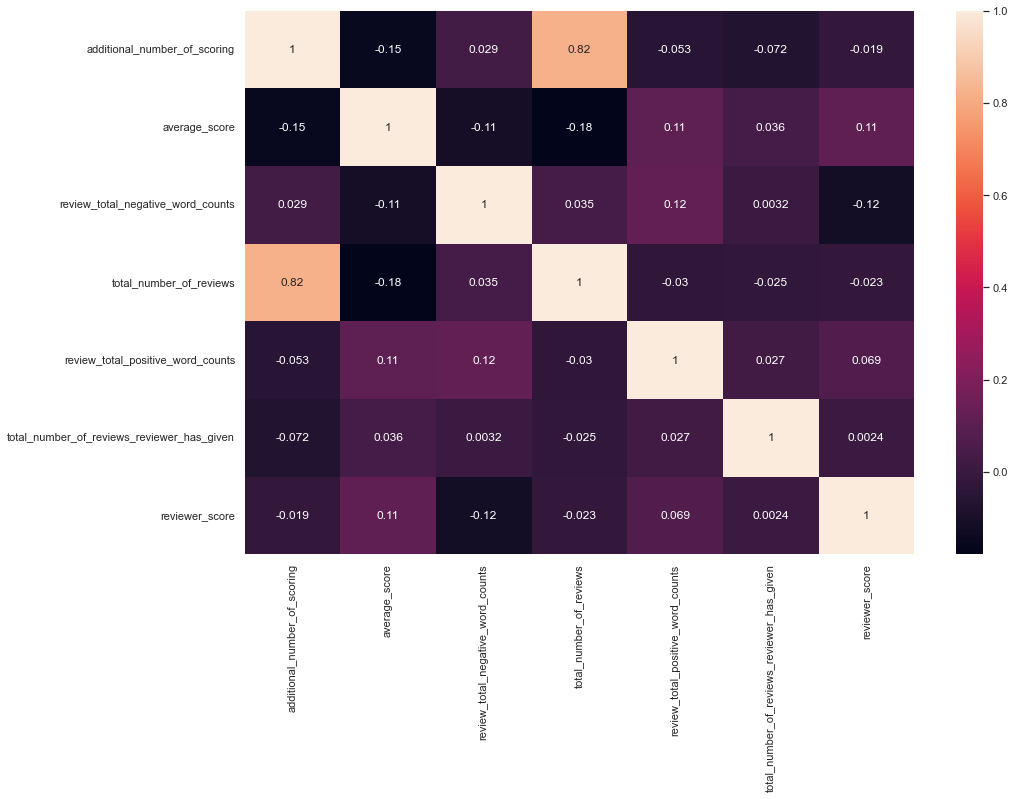

In [16]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [17]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 8 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 31.5 MB


In [19]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [20]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [21]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 7), (386803, 7), (386803, 6), (309442, 6), (77361, 6))

In [22]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [23]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [24]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отеля в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


In [25]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9823059147830512


<AxesSubplot:>

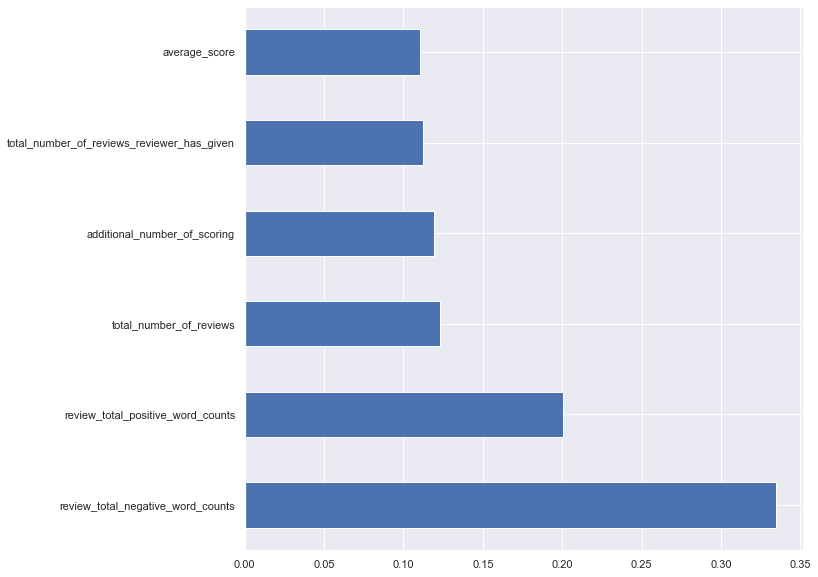

In [26]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [27]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score
60386,18,8.30,0,156,19,13,0.00
89679,239,8.40,2,2349,8,36,0.00
112015,926,8.20,26,5770,23,8,0.00
48318,235,9.30,0,769,21,3,0.00
127285,417,6.70,67,2400,2,1,0.00
112783,420,8.60,2,4379,12,1,0.00
59772,234,9.30,0,1075,25,1,0.00
36422,387,8.50,0,1593,44,1,0.00
60932,119,8.90,0,394,16,19,0.00
76790,147,8.60,36,1562,32,52,0.00


In [28]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [29]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [30]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


In [31]:
predict_submission

array([8.502 , 8.08  , 7.968 , ..., 8.43  , 9.617 , 7.9375])

In [32]:
list(sample_submission)

['reviewer_score', 'id']

In [33]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.50,488440
1,8.08,274649
2,7.97,374688
3,9.52,404352
4,9.42,451596
5,8.83,302161
6,6.80,317079
7,7.82,13963
8,9.13,159785
9,8.11,195089


In [34]:
sample_submission

,reviewer_score,id
0,8.50,488440
1,8.08,274649
2,7.97,374688
3,9.52,404352
4,9.42,451596
...,...,...
128930,9.12,495812
128931,5.74,315577
128932,8.43,511968
128933,9.62,303386
